<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Online%20Grocery%20IRI%20US/Prophet%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 5.2 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 179 kB 55.3 MB/s 
     |████████████████████████████████| 45 kB 663 kB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.


In [2]:
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
data_url ="https://raw.githubusercontent.com/Coresight-Adithya/Automated-Projections/main/Edible%20CPG%20IRI%20US/Edible%20TOtal%20CPG.csv" 
data_name = "Edible CPG IRI"
df = pd.read_csv(data_url)
print(df)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.columns = ['ds', 'y']
df['y'] = df['y'].astype(float)
df = df.dropna()

          Date       Sales 
0   31-01-2016  37878013723
1   28-02-2016  39203208315
2   27-03-2016  39747288435
3   24-04-2016  38314607367
4   22-05-2016  38992076713
..         ...          ...
79  20-02-2022  55755170152
80  20-03-2022  55447990236
81  17-04-2022  57423119211
82  15-05-2022  56449057207
83  12-06-2022  58589380851

[84 rows x 2 columns]


In [4]:
dates = pd.DataFrame(pd.date_range("01-31-2016", periods=91, freq="4W"))

In [5]:
dates.to_csv("dates.csv")

In [6]:
# COVID Outliers
covid_outlier_st = datetime.strptime('2020-03-01', '%Y-%m-%d').date()
covid_outlier_en = datetime.strptime('2020-05-31', '%Y-%m-%d').date()

df.loc[(df['ds'].dt.date >= covid_outlier_st) & (df['ds'].dt.date <= covid_outlier_en), 'y'] = None

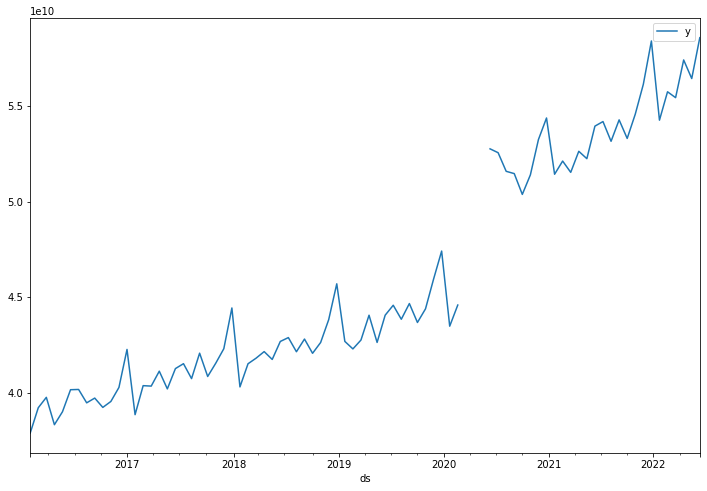

In [7]:
df.plot(x='ds', y='y', figsize=(12,8))

In [8]:
# Facebook Prophet Model
model = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, weekly_seasonality=False)
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprlcddyym/40ibijw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprlcddyym/ssflm6t6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15158', 'data', 'file=/tmp/tmprlcddyym/40ibijw1.json', 'init=/tmp/tmprlcddyym/ssflm6t6.json', 'output', 'file=/tmp/tmppdgrqjcv/prophet_model-20220725120226.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
# Make future dates
future = model.make_future_dataframe(periods=68, freq='4W')
future = future[future['ds'].dt.year <= datetime.now().year+6]
future

,ds
0,2016-01-31
1,2016-02-28
2,2016-03-27
3,2016-04-24
4,2016-05-22
...,...
147,2027-05-09
148,2027-06-06
149,2027-07-04
150,2027-08-01


In [10]:
# Forecast
forecast = model.predict(future)

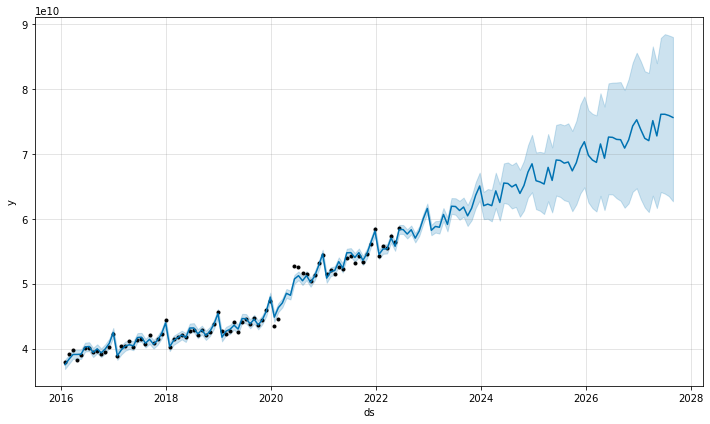

In [11]:
model.plot(forecast);

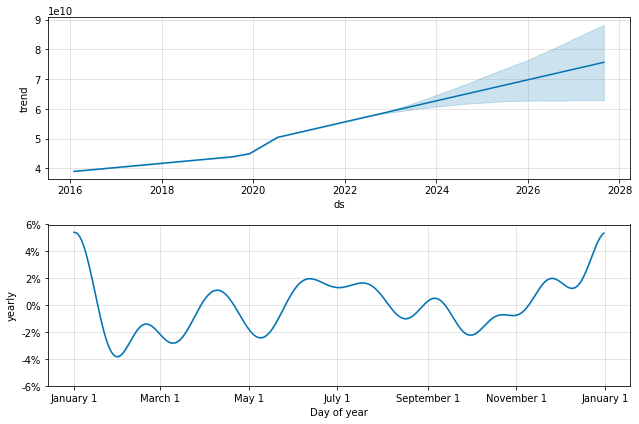

In [12]:
model.plot_components(forecast);

In [13]:

forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].to_csv(data_name+'-Prophet-Predictions.csv')